# Plant Seedlings Classification using balanced dataset
Determine the species of a seedling from an image

- load and normalize the data

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division

In [3]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

In [5]:
import torchvision
from torchvision import transforms, datasets, models
import torchvision.transforms.functional as TF

In [6]:
plt.ion()

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## load and normalize the data

In [8]:
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.3200, 0.2880, 0.1953], [0.0840, 0.0874, 0.0952])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.3200, 0.2880, 0.1953], [0.0840, 0.0874, 0.0952])
    ]),
    'tes': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.3200, 0.2880, 0.1953], [0.0840, 0.0874, 0.0952])
    ])
}

In [9]:
path = './data/balanced'

**datasets**

In [10]:
image_datasets = {x: datasets.ImageFolder(os.path.join(path, x), transform[x]) 
                  for x in ['train', 'val', 'tes']}

**data loader**

In [11]:
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=4)
                for x in ['train', 'val']}

**number of images**

In [12]:
nb_images = {x: len(image_datasets[x]) for x in ['train', 'val', 'tes']}
nb_images

{'tes': 794, 'train': 6290, 'val': 947}

**classes**

In [13]:
class_names = image_datasets['train'].classes
class_names

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

**mean and std**

In [ ]:
mean = 0.
std = 0.

for images, labels in data_loaders['train']:
    images, labels = images.to(device), labels.to(device)
    
    # get number of images in the batch and number of channels
    batch_size = images.size(0)
    nb_channels = images.size(1)
    
    # flatten height and width into one axis
    images = images.view(batch_size, nb_channels, -1)
    # get mean and std
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    
mean /= nb_images['train']
std /= nb_images['train']

print('mean: ', mean)
print('std: ', std)

## visualize some images

In [14]:
def imshow(inp, title=None):
    # convert to numpy array and transpose
    inp = inp.numpy().transpose([1, 2, 0])
    # mean and std used for normalization
    mean = np.asarray([0.3200, 0.2880, 0.1953])
    std = np.asarray([0.0840, 0.0874, 0.0952])
    # unnormalize
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

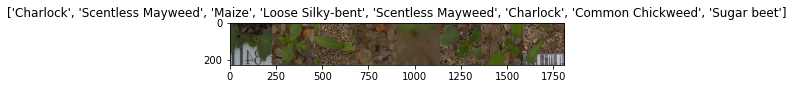

In [16]:
train_iter = iter(data_loaders['train'])
images, labels = train_iter.next()

grid = torchvision.utils.make_grid(images)
title = [class_names[x] for x in labels]

imshow(grid, title=title)

## define train function

In [15]:
def train(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        # each epoch has a training and a validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                scheduler.step()
            else:
                model.eval()
            
            running_loss = 0.
            running_corrects = 0.
            for images, labels in data_loaders[phase]:
                images, labels = images.to(device), labels.to(device)
                # zero the gradient buffer
                optimizer.zero_grad()
                # forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)

                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # stats
                running_loss += loss.item() * labels.size(0)
                running_corrects += (preds == labels).sum().item()

            epoch_loss = running_loss / nb_images[phase]
            epoch_acc = running_corrects / nb_images[phase]

            print('{} Loss: {:.4f}  Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_model_wts = copy.deepcopy(model.state_dict())
                best_acc = epoch_acc

        print()
    
    time_elapsed = time.time() - since
    print('Training complete in: {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best validation acc: {:.4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model   

## generic function to display predictions of a few images

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    images_so_far = 0
    model.eval()
    fig = plt.figure()
    
    with torch.no_grad():
        for images, labels in data_loaders['val']:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(images.cpu().data[j])
                
            if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## create fully connected network

In [19]:
class FullyConnected(nn.Module):
    def __init__(self, nb_classes):
        super(FullyConnected, self).__init__()
        
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, nb_classes)
        
    def forward(self, x):
        x = self.dropout(x)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [20]:
fc_net = FullyConnected(len(class_names)).to(device)

## define and freeze conv_base

In [21]:
conv_base = models.resnet50(pretrained=True)
conv_base = conv_base.to(device)

**freeze weights**

In [22]:
for param in conv_base.parameters():
    param.requires_grad = False

**replace fully connected layer**

In [23]:
num_ftrs = conv_base.fc.in_features
conv_base.fc = nn.Linear(num_ftrs, 1024)

## combine conv_base and fc layers

In [24]:
model = nn.Sequential(conv_base, fc_net)
model = model.to(device)

## define loss function

In [25]:
criterion = nn.CrossEntropyLoss()

## define optimizer and scheduler

In [26]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
scheduler = lr_scheduler.StepLR(optimizer, 7, gamma=0.1)

## train model

In [28]:
model = train(model, criterion, optimizer, scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 1.9238  Acc: 0.3315
val Loss: 1.3999  Acc: 0.5396

Epoch 2/25
----------
train Loss: 1.2726  Acc: 0.5561
val Loss: 0.9769  Acc: 0.6410

Epoch 3/25
----------
train Loss: 1.1415  Acc: 0.6087
val Loss: 0.8210  Acc: 0.6927

Epoch 4/25
----------
train Loss: 1.0567  Acc: 0.6323
val Loss: 0.7854  Acc: 0.7054

Epoch 5/25
----------
train Loss: 1.0454  Acc: 0.6437
val Loss: 0.8454  Acc: 0.6832

Epoch 6/25
----------
train Loss: 1.0224  Acc: 0.6471
val Loss: 0.8744  Acc: 0.6758

Epoch 7/25
----------
train Loss: 0.9686  Acc: 0.6707
val Loss: 0.6674  Acc: 0.7518

Epoch 8/25
----------
train Loss: 0.8328  Acc: 0.7119
val Loss: 0.6032  Acc: 0.7814

Epoch 9/25
----------
train Loss: 0.7894  Acc: 0.7256
val Loss: 0.5994  Acc: 0.7687

Epoch 10/25
----------
train Loss: 0.7807  Acc: 0.7291
val Loss: 0.5854  Acc: 0.7719

Epoch 11/25
----------
train Loss: 0.7833  Acc: 0.7266
val Loss: 0.5911  Acc: 0.7761

Epoch 12/25
----------
train Loss: 0.7609  Acc: 0.7361
val Loss

## fine tuning

In [29]:
for param in model.parameters():
    param.requires_grad = True

In [30]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [31]:
model = train(model, criterion, optimizer, scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.5790  Acc: 0.8002
val Loss: 0.4186  Acc: 0.8553

Epoch 2/25
----------
train Loss: 0.3658  Acc: 0.8781
val Loss: 0.2169  Acc: 0.9314

Epoch 3/25
----------
train Loss: 0.2863  Acc: 0.8994
val Loss: 0.2638  Acc: 0.9102

Epoch 4/25
----------
train Loss: 0.2467  Acc: 0.9157
val Loss: 0.2015  Acc: 0.9293

Epoch 5/25
----------
train Loss: 0.2406  Acc: 0.9154
val Loss: 0.2019  Acc: 0.9419

Epoch 6/25
----------
train Loss: 0.2167  Acc: 0.9266
val Loss: 0.2657  Acc: 0.9219

Epoch 7/25
----------
train Loss: 0.2132  Acc: 0.9280
val Loss: 0.3411  Acc: 0.8997

Epoch 8/25
----------
train Loss: 0.1977  Acc: 0.9335
val Loss: 0.1845  Acc: 0.9461

Epoch 9/25
----------
train Loss: 0.2192  Acc: 0.9281
val Loss: 0.1709  Acc: 0.9535

Epoch 10/25
----------
train Loss: 0.1725  Acc: 0.9429
val Loss: 0.1632  Acc: 0.9546

Epoch 11/25
----------
train Loss: 0.1624  Acc: 0.9409
val Loss: 0.2030  Acc: 0.9377

Epoch 12/25
----------
train Loss: 0.1739  Acc: 0.9397
val Loss

In [52]:
optimizer = optim.Adam(model.parameters(), lr=0.0000001)

In [53]:
model = train(model, criterion, optimizer, scheduler, num_epochs=5)

Epoch 1/5
----------
train Loss: 0.0683  Acc: 0.9771
val Loss: 0.1288  Acc: 0.9704

Epoch 2/5
----------
train Loss: 0.0593  Acc: 0.9779
val Loss: 0.1337  Acc: 0.9683

Epoch 3/5
----------
train Loss: 0.0709  Acc: 0.9790
val Loss: 0.1306  Acc: 0.9683

Epoch 4/5
----------
train Loss: 0.0680  Acc: 0.9771
val Loss: 0.1320  Acc: 0.9683

Epoch 5/5
----------
train Loss: 0.0685  Acc: 0.9776
val Loss: 0.1292  Acc: 0.9715

Training complete in: 2m 15s
Best validation acc: 0.9715


## evaluate on test set

In [42]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """
    def __init__(self, path, transform):
        super(ImageFolderWithPaths, self).__init__(path, transform=transform)

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [43]:
# instantiate the dataset and dataloader
test_dataset = ImageFolderWithPaths('./data/balanced/tes', transform['tes']) # our custom dataset
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [44]:
model = model.eval()

In [45]:
test_filenames = []
test_predictions = []

In [46]:
for images, labels, paths in test_dataloader:
    images, labels = images.to(device), labels.to(device)
    
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    
    predicted_classes = [class_names[i.item()] for i in preds]
    filenames = [path[25:] for path in paths]
    
    test_filenames.extend(filenames)
    test_predictions.extend(predicted_classes)

In [47]:
len(test_predictions)

794

In [48]:
results=pd.DataFrame({"file":test_filenames,
                      "species":test_predictions})
results.to_csv("results.csv",index=False)